**Автор: Анна Смелова**

## Решение домашнего задания к уроку 6 "Градиентный бустинг. AdaBoost"

In [1]:
import matplotlib.pyplot as plt
import random

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
# Реализуем класс узла
class Node_r:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [4]:
# Класс терминального узла (листа)
class Leaf_r:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
            
    def predict(self):    
        prediction = np.mean(self.labels)
        return prediction   

In [5]:
# Класс дерева
class Tree_r:
    
    def __init__(self, max_depth=100, 
                 max_leaf_num=100, 
                 min_leaf_object=1):
        
        self.max_depth = max_depth
        self.nodes = []
        self.leaves = []
        self.depth = 0
        self.max_leaves = max_leaf_num
        self.min_objects = min_leaf_object
        
        self.tree = None
        
    
    # Расчет среднеквадратичного отклонения
    def mse(self, labels):
        mean = labels.mean()
        return np.mean((labels - mean)**2)
    
    # Расчет прироста
    def gain(self, left_labels, right_labels, root_mse):
        # доля выборки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        
        gain = root_mse - p * self.mse(left_labels) - (1 - p) * self.mse(right_labels)
        if gain > 0:
            return gain
        else:
            return 0

    # Разбиение датасета в узле
    def split(self, data, labels, column_index, t):
        left = np.where(data[:, column_index] <= t)
        right = np.where(data[:, column_index] > t)

        true_data = data[left]
        false_data = data[right]

        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels):
        #  обозначим минимальное количество объектов в узле
        min_samples_leaf = 5

        root_mse = self.mse(labels)

        best_gain = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique(data[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                    continue

                current_gain = self.gain(true_labels, false_labels, root_mse)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_gain > best_gain:
                    best_gain, best_t, best_index = current_gain, t, index

        return best_gain, best_t, best_index
    
    # Построение дерева с помощью рекурсивной функции
    def build_tree(self, data, labels):
        gain, t, index = self.find_best_split(data, labels)
        
        #  Базовый случай 1 - прекращаем рекурсию, когда нет прироста в качества
        if gain == 0:
            self.leaves.append(Leaf_r(data, labels))
            return Leaf_r(data, labels)
 
        #  Базовый случай 2 - прекращаем рекурсию, когда достигли максимальной глубины дерева
        if self.depth >= self.max_depth:
            self.leaves.append(Leaf_r(data, labels))
            return Leaf_r(data, labels)
        
        #  Базовый случай 3 - прекращаем рекурсию, когда достигли максимального количества листьев
        if len(self.leaves) >= self.max_leaves - 1 or self.depth >= self.max_leaves - 1:
            self.leaves.append(Leaf_r(data, labels))
            return Leaf_r(data, labels)
        
        #  Базовый случай 4 - прекращаем рекурсию, когда достигли минимального количества объектов в листе
        if len(data) <= self.min_objects:
            self.leaves.append(Leaf_r(data, labels))
            return Leaf_r(data, labels)
        
        self.depth += 1
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.nodes.append(Node_r(index, t, true_branch, false_branch))
        return Node_r(index, t, true_branch, false_branch)
    
    def classify_object(self, obj, node):
        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf_r):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
    
    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels)
        return self
    
    def predict(self, data):
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.tree)
            classes.append(prediction)
        return classes

### Задание 1
Используя файл Lesson_6_extended.ipynb (он в web6.zip в материалах):
#### Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [6]:
# Класс для градиентного бустинга
class GB_Tree_r:
    
    def __init__(self, n_trees, 
                 max_depth=100,
                 max_leaf_num=100,
                 min_leaf_object=1,
                 eta = 1):
        
        self.n_trees = n_trees #число деревьев в ансабле
        self.max_depth = max_depth #ограничение максимальной глубины деревьев в ансабле
        self.max_leaf_num = max_leaf_num #ограничение максимального числа листьев в деревьях
        self.min_leaf_object = min_leaf_object #ограничние минимльного количества объектов в листе
        self.eta =eta # шаг градиентного бустинга
        self.trees_list = [] #список деревьев в ансабле 
        self.trees_predicts=[]
        #self.bootstrap = []
        #self.sample_indexes = None
        
    # Функция, реализующая предсказание в градиентном бустинге
    def predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
        # прибавляются с шагом eta
        '''
        predictions = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            prediction = 0
            for alg in self.trees_list:
                prediction += self.eta * alg.predict([x])[0]
            predictions[i] = prediction
        '''

        predictions = np.array(
            [sum([self.eta * alg.predict([x])[0] for alg in self.trees_list]) for x in X]
        )

        return predictions
    
    # В качестве функционала ошибки будем использовать среднеквадратичную ошибку
    def mean_squared_error(self, y_real, prediction):
        return (sum((y_real - prediction)**2)) / len(y_real)
    
    def residual(self, y, z):
        return - (z - y)
    
    # Функция обучения градиентного бустинга
    def fit(self, X_train, X_test, y_train, y_test):
        # Деревья будем записывать в список
        self.trees_list = []
        # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
        train_errors = []
        test_errors = []

        for i in range(self.n_trees):
            tree = Tree_r(max_depth=self.max_depth, max_leaf_num=self.max_leaf_num, min_leaf_object=self.min_leaf_object)

            # первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.trees_list) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X_train, y_train)

                train_errors.append(self.mean_squared_error(y_train, self.predict(X_train)))
                test_errors.append(self.mean_squared_error(y_test, self.predict(X_test)))
            else:
                # Получим ответы на текущей композиции
                target = self.predict(X_train)

                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train, self.residual(y_train, target))

                train_errors.append(self.mean_squared_error(y_train, self.predict(X_train)))
                test_errors.append(self.mean_squared_error(y_test, self.predict(X_test)))

            self.trees_list.append(tree)

        return self.trees_list, train_errors, test_errors

In [7]:
# Загрузим данные
X, y = load_diabetes(return_X_y=True)
# И разделим выборку на обучающую и тестовую в соотношении 75/25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

**Сначала построим график зависимости ошибки от количества деревьев в ансамбле**<br>
Построим два графика: один со значениями количества деревьев до 30, второй с бОльшим количеством деревьев.

In [8]:
# Максимальная глубина деревьев
max_depth = 3
# Шаг
eta = 0.1
# Число деревьев в ансамбле
a_trees_1 = [1, 5, 10, 20, 30, 50, 100, 150]
a_trees_2 = [1, 5, 10, 15, 17, 19, 21, 23, 25, 27, 30]

In [9]:
%%time
train_errors_1 = []
test_errors_1 = []
for n_trees in a_trees_1:
    alg = GB_Tree_r(n_trees=n_trees, max_depth=max_depth, eta=eta)
    trees, trn_errors, tst_errors= alg.fit(X_train, X_test, y_train, y_test) 
    train_prediction_1 = alg.predict(X_train)
    test_prediction_1 = alg.predict(X_test)
    train_errors_1.append(alg.mean_squared_error(y_train, train_prediction_1))
    test_errors_1.append(alg.mean_squared_error(y_test, test_prediction_1))

CPU times: user 2min 6s, sys: 966 ms, total: 2min 6s
Wall time: 2min 15s


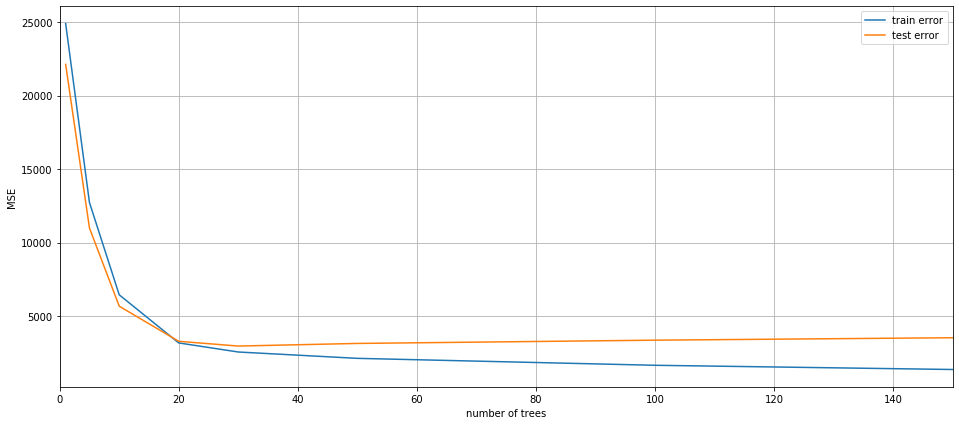

In [10]:
plt.figure(figsize = (16, 7))
plt.xlabel('number of trees')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(a_trees_1, train_errors_1, label='train error')
plt.plot(a_trees_1, test_errors_1, label='test error')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [11]:
%%time
train_errors_2 = []
test_errors_2 = []
for n_trees in a_trees_2:
    alg = GB_Tree_r(n_trees=n_trees, max_depth=max_depth, eta=eta)
    trees, trn_errors, tst_errors= alg.fit(X_train, X_test, y_train, y_test) 
    train_prediction_2 = alg.predict(X_train)
    test_prediction_2 = alg.predict(X_test)
    train_errors_2.append(alg.mean_squared_error(y_train, train_prediction_2))
    test_errors_2.append(alg.mean_squared_error(y_test, test_prediction_2))

CPU times: user 46.9 s, sys: 41 ms, total: 46.9 s
Wall time: 47 s


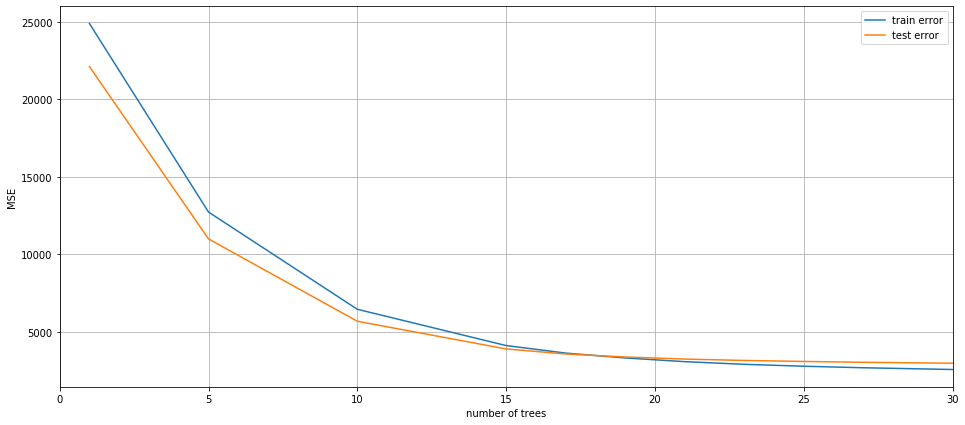

In [12]:
plt.figure(figsize = (16, 7))
plt.xlabel('number of trees')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(a_trees_2, train_errors_2, label='train error')
plt.plot(a_trees_2, test_errors_2, label='test error')
plt.legend(loc='upper right')
plt.grid()
plt.show()

**Вывод:** получилось, что оптимальное количество деревьев 30, далее ошибка на тренировочной выборке постепенно снижается до нуля, а ошибка на тестовой выборке возрастает, то есть идет переобучение.

**Теперь построим график зависимости ошибки от максимальной глубины деревьев в ансамбле**

In [13]:
# Шаг
eta = 0.1
# Число деревьев в ансамбле
n_trees = 30
# Глубина деревьев
a_depths_1 = [1, 10, 30, 50, 75]
a_depths_2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [14]:
%%time
train_errors_3 = []
test_errors_3 = []
for max_depth in a_depths_1:
    alg = GB_Tree_r(n_trees=n_trees, max_depth=max_depth, eta=eta)
    trees, trn_errors, tst_errors= alg.fit(X_train, X_test, y_train, y_test) 
    train_prediction_3 = alg.predict(X_train)
    test_prediction_3 = alg.predict(X_test)
    train_errors_3.append(alg.mean_squared_error(y_train, train_prediction_3))
    test_errors_3.append(alg.mean_squared_error(y_test, test_prediction_3))

CPU times: user 1min 11s, sys: 158 ms, total: 1min 12s
Wall time: 1min 13s


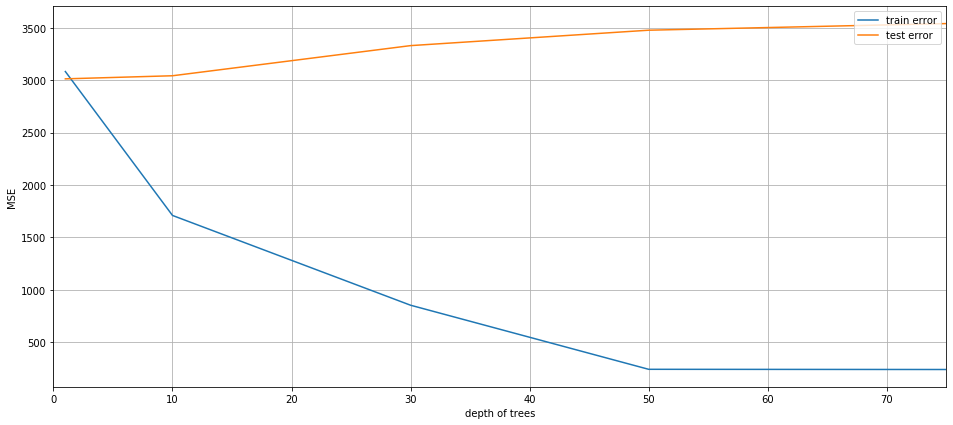

In [15]:
plt.figure(figsize = (16, 7))
plt.xlabel('depth of trees')
plt.ylabel('MSE')
plt.xlim(0, max_depth)
plt.plot(a_depths_1, train_errors_3, label='train error')
plt.plot(a_depths_1, test_errors_3, label='test error')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [16]:
%%time
train_errors_4 = []
test_errors_4 = []
for max_depth in a_depths_2:
    alg = GB_Tree_r(n_trees=n_trees, max_depth=max_depth, eta=eta)
    trees, trn_errors, tst_errors= alg.fit(X_train, X_test, y_train, y_test) 
    train_prediction_4 = alg.predict(X_train)
    test_prediction_4 = alg.predict(X_test)
    train_errors_4.append(alg.mean_squared_error(y_train, train_prediction_4))
    test_errors_4.append(alg.mean_squared_error(y_test, test_prediction_4))

CPU times: user 1min 29s, sys: 192 ms, total: 1min 29s
Wall time: 1min 31s


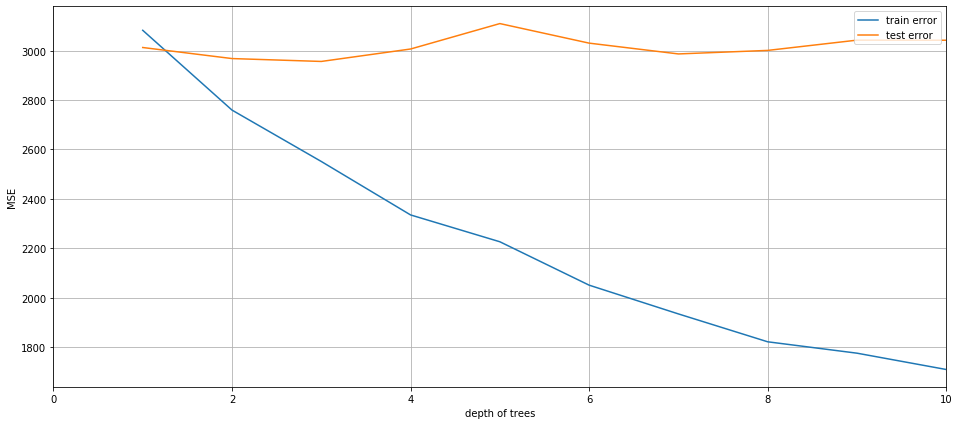

In [17]:
plt.figure(figsize = (16, 7))
plt.xlabel('depth of trees')
plt.ylabel('MSE')
plt.xlim(0, max_depth)
plt.plot(a_depths_2, train_errors_4, label='train error')
plt.plot(a_depths_2, test_errors_4, label='test error')
plt.legend(loc='upper right')
plt.grid()
plt.show()

**Вывод:** здесь получилось, что оптимальная глубина 3, далее опять идет переобучение.

Посмотрим, как выглядит предсказание в проекции на первый признак для оптимальных параметров:

In [18]:
%%time
alg = GB_Tree_r(n_trees=30, max_depth=3, eta=0.1)
trees, trn_errors, tst_errors= alg.fit(X_train, X_test, y_train, y_test) 
train_prediction = alg.predict(X_train)
test_prediction = alg.predict(X_test)
train_error = alg.mean_squared_error(y_train, train_prediction)
test_error = alg.mean_squared_error(y_test, test_prediction)

CPU times: user 7.26 s, sys: 7.52 ms, total: 7.27 s
Wall time: 7.28 s


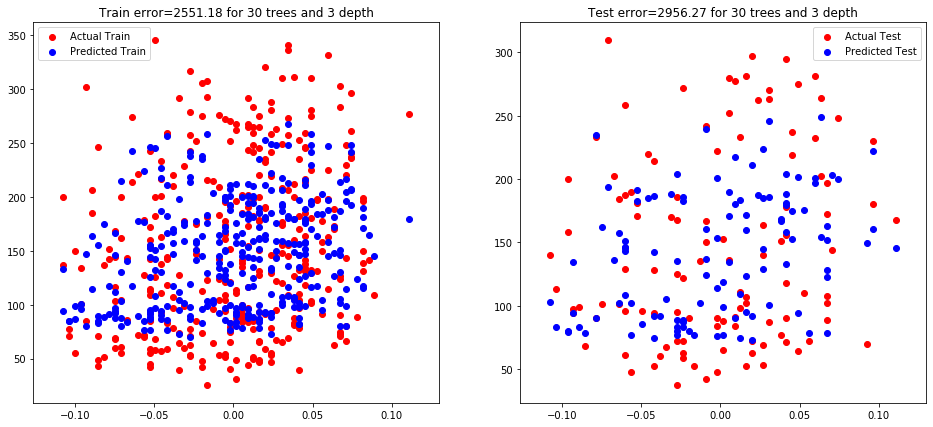

In [19]:
plt.figure(figsize = (16, 7))
plt.subplot(1,2,1)
plt.scatter(X_train[:,0], y_train, c='r', label='Actual Train')
plt.scatter(X_train[:,0], train_prediction, c='b', label='Predicted Train')
plt.title(f'Train error={train_error:.2f} for {alg.n_trees} trees and {alg.max_depth} depth')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(X_test[:,0], y_test, c='r', label='Actual Test')
plt.scatter(X_test[:,0], test_prediction, c='b', label='Predicted Test')
plt.title(f'Test error={test_error:.2f} for {alg.n_trees} trees and {alg.max_depth} depth')
plt.legend()

plt.show()

А если особо не ограничивать, то очень хорошо видно переобучение

In [20]:
%%time
alg = GB_Tree_r(n_trees=100, eta=0.1)
trees, trn_errors, tst_errors= alg.fit(X_train, X_test, y_train, y_test) 
train_prediction = alg.predict(X_train)
test_prediction = alg.predict(X_test)
train_error = alg.mean_squared_error(y_train, train_prediction)
test_error = alg.mean_squared_error(y_test, test_prediction)

CPU times: user 1min 36s, sys: 158 ms, total: 1min 36s
Wall time: 1min 37s


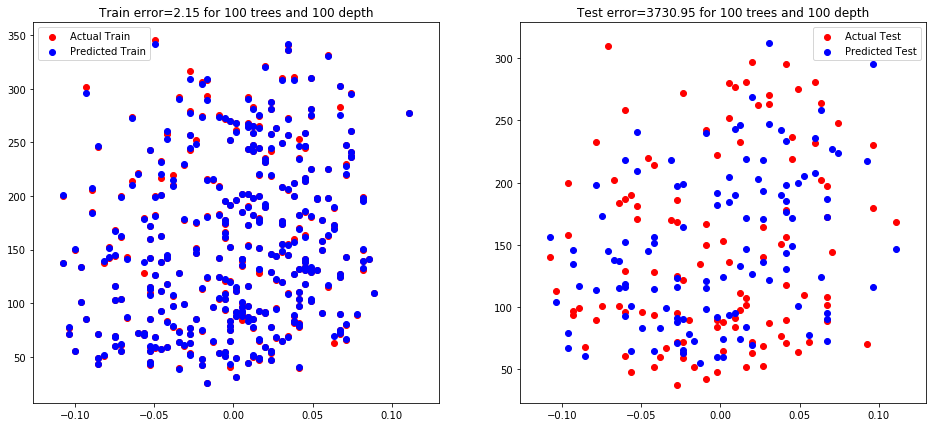

In [21]:
plt.figure(figsize = (16, 7))
plt.subplot(1,2,1)
plt.scatter(X_train[:,0], y_train, c='r', label='Actual Train')
plt.scatter(X_train[:,0], train_prediction, c='b', label='Predicted Train')
plt.title(f'Train error={train_error:.2f} for {alg.n_trees} trees and {alg.max_depth} depth')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(X_test[:,0], y_test, c='r', label='Actual Test')
plt.scatter(X_test[:,0], test_prediction, c='b', label='Predicted Test')
plt.title(f'Test error={test_error:.2f} for {alg.n_trees} trees and {alg.max_depth} depth')
plt.legend()

plt.show()

### Задание 2*
Используя файл Lesson_6_extended.ipynb (он в web6.zip в материалах):
#### Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [22]:
# ИЗМЕНЕНИЯ параметр size, если указан, то берется указанная часть выборки train_ind для предсказания(в функции fit)
# Класс для стохастического градиентного бустинга
class SGB_Tree_r:
    
    def __init__(self, n_trees, 
                 max_depth=100,
                 max_leaf_num=100,
                 min_leaf_object=1,
                 eta = 1,
                 size=1):
        
        self.n_trees = n_trees #число деревьев в ансабле
        self.max_depth = max_depth #ограничение максимальной глубины деревьев в ансабле
        self.max_leaf_num = max_leaf_num #ограничение максимального числа листьев в деревьях
        self.min_leaf_object = min_leaf_object #ограничние минимального количества объектов в листе
        self.eta =eta # шаг градиентного бустинга
        self.trees_list = [] #список деревьев в ансабле 
        self.trees_predicts=[]
        self.size = size #размер подвыборки(доля)
        
    # Функция, реализующая предсказание в градиентном бустинге
    def predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
        # прибавляются с шагом eta
        
        '''
        predictions = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            prediction = 0
            for alg in self.trees_list:
                prediction += self.eta * alg.predict([x])[0]
            predictions[i] = prediction
        '''
        
        predictions = np.array(
            [sum([self.eta * alg.predict([x])[0] for alg in self.trees_list]) for x in X]
        )

        return predictions
    
    # В качестве функционала ошибки будем использовать среднеквадратичную ошибку
    def mean_squared_error(self, y_real, prediction):
        return (sum((y_real - prediction)**2)) / len(y_real)
    
    def residual(self, y, z):
        return - (z - y)
    
    # Функция обучения градиентного бустинга
    def fit(self, X_train, X_test, y_train, y_test):
        # Деревья будем записывать в список
        self.trees_list = []
        # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
        train_errors = []
        test_errors = []

        for i in range(self.n_trees):
            # ИЗМЕНЕНИЯ
            # Каждую итерацию учим на новой подвыборке
            train_ind = np.random.randint(X_train.shape[0], size=int(self.size*X_train.shape[0]))
            X_train_sub = X_train[train_ind]
            y_train_sub = y_train[train_ind]
            
            tree = Tree_r(max_depth=self.max_depth, max_leaf_num=self.max_leaf_num, min_leaf_object=self.min_leaf_object)

            # первый алгоритм просто обучаем на подвыборке и добавляем в список
            if len(self.trees_list) == 0:
                # обучаем первое дерево на обучающей подвыборке
                tree.fit(X_train_sub, y_train_sub)

                # Ошибку считаем на тренировочной ПОДвыборке и на всей тестовой выборке
                train_errors.append(self.mean_squared_error(y_train_sub, self.predict(X_train_sub)))
                test_errors.append(self.mean_squared_error(y_test, self.predict(X_test)))
            else:
                # Получим ответы на текущей композиции
                target = self.predict(X_train_sub)

                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train_sub, self.residual(y_train_sub, target))

                # Ошибку считаем на тренировочной ПОДвыборке и на всей тестовой выборке
                train_errors.append(self.mean_squared_error(y_train_sub, self.predict(X_train_sub)))
                test_errors.append(self.mean_squared_error(y_test, self.predict(X_test)))

            self.trees_list.append(tree)

        return self.trees_list, train_errors, test_errors

Построим кривые изменения ошибки для градиентного бустинга и стохастического градиентного бустинга на тренировочной и тестовой выборках в зависимости от числа итераций.

In [23]:
# Число деревьев в ансамбле
n_trees = 100
# Максимальная глубина деревьев
max_depth = 3
# Шаг
eta = 0.1

In [24]:
%%time
#Градиентный бустинг
gb=GB_Tree_r(n_trees=n_trees, max_depth=max_depth, eta=eta)
trees_gb, train_errors_gb, test_errors_gb = gb.fit(X_train, X_test, y_train, y_test)

CPU times: user 31.2 s, sys: 164 ms, total: 31.4 s
Wall time: 33 s


In [25]:
%%time
#Стохастический градиентный бустинг
sgb=SGB_Tree_r(n_trees=n_trees, max_depth=max_depth, eta=eta, size=0.5)
trees_sgb, train_errors_sgb, test_errors_sgb = sgb.fit(X_train, X_test, y_train, y_test)

CPU times: user 15.1 s, sys: 21.9 ms, total: 15.1 s
Wall time: 15.1 s


In [26]:
def get_error_plot(n_trees, err_gb, err_sgb, title):
    plt.figure(figsize = (16, 16))
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), err_gb, label='GB')
    plt.plot(list(range(n_trees)), err_sgb, label='SGB')
    plt.legend(loc='lower left')
    plt.title(f'{title}')
    plt.show()

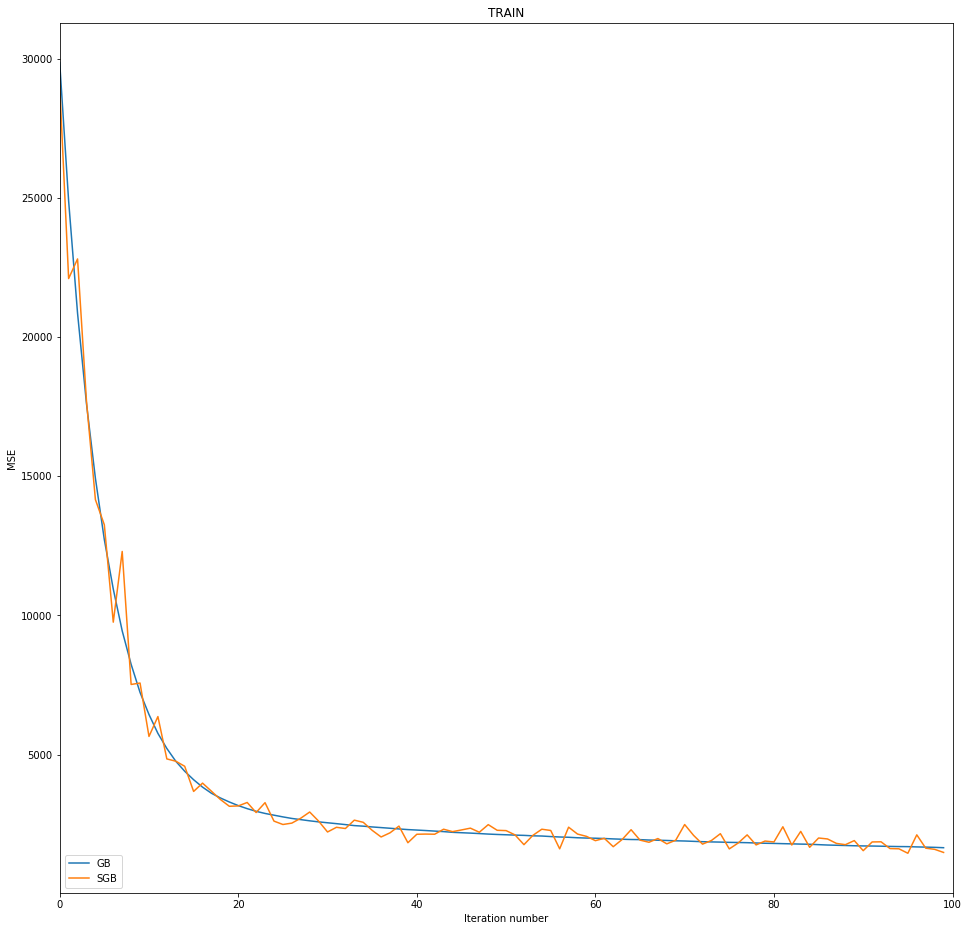

In [27]:
get_error_plot(n_trees, train_errors_gb, train_errors_sgb, 'TRAIN')

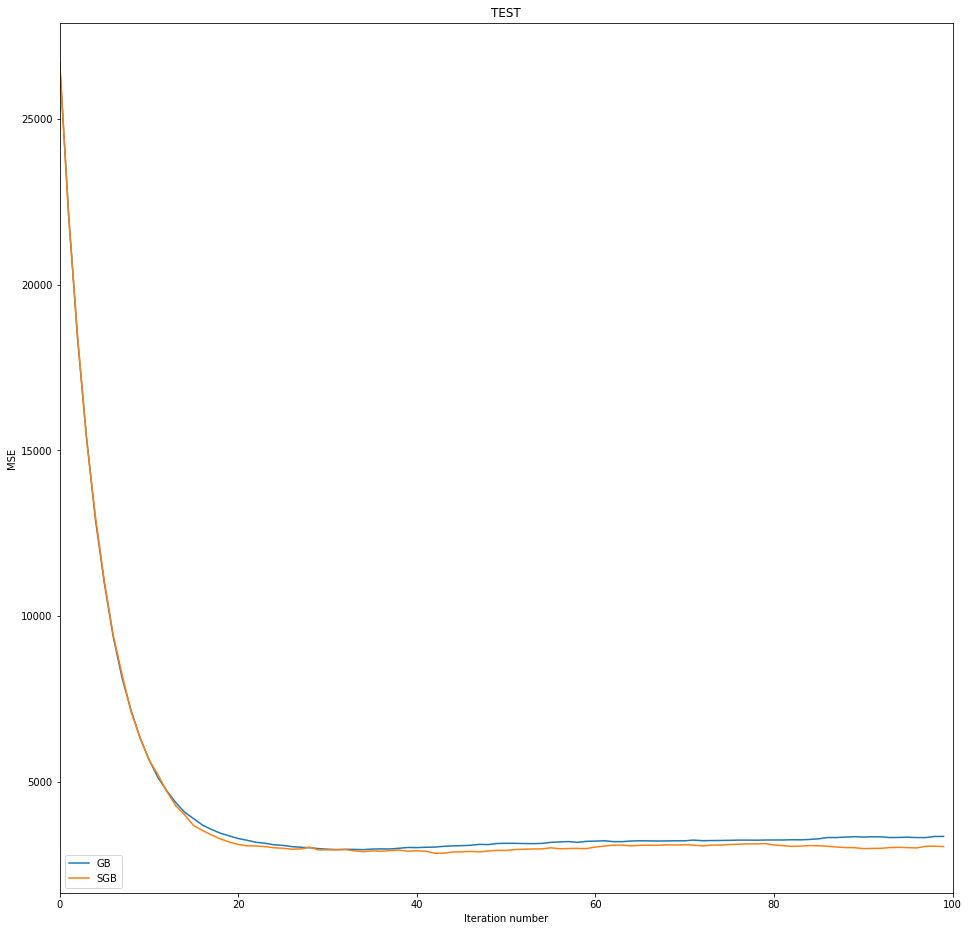

In [28]:
get_error_plot(n_trees, test_errors_gb, test_errors_sgb, 'TEST')

Посмотрим все вместе на одном графике

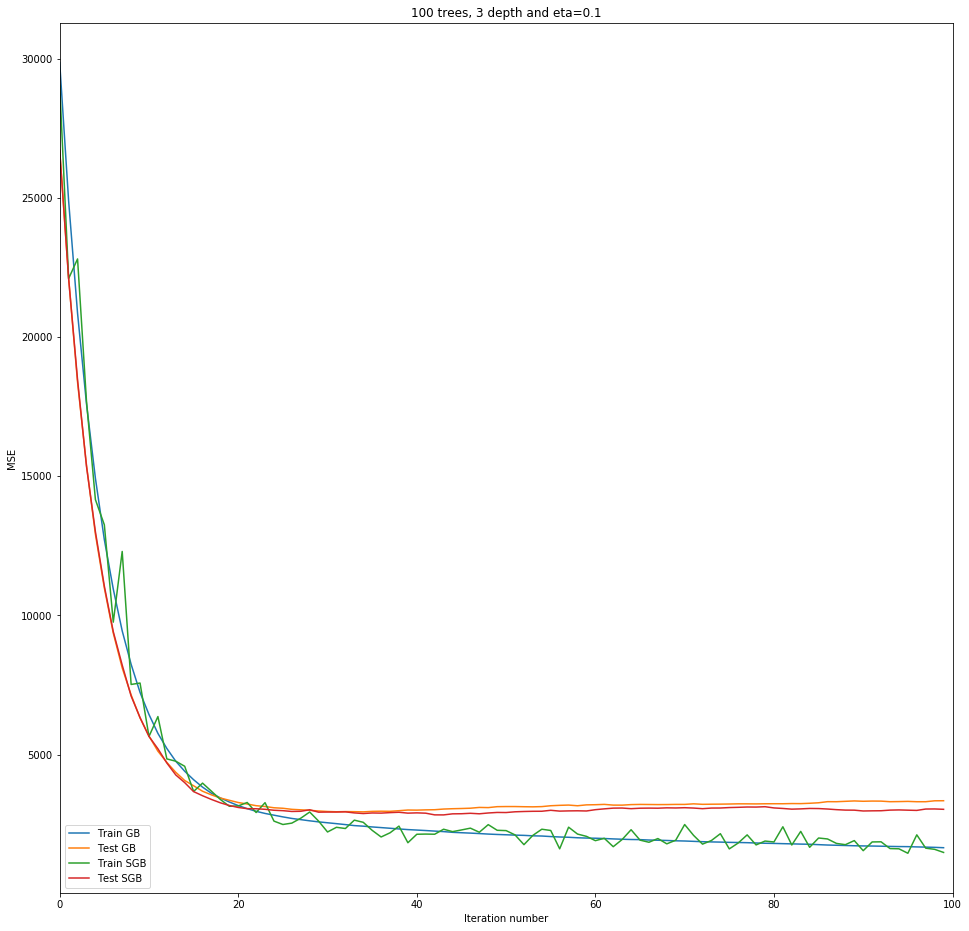

In [29]:
plt.figure(figsize = (16, 16))
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(list(range(n_trees)), train_errors_gb, label='Train GB')
plt.plot(list(range(n_trees)), test_errors_gb, label='Test GB')
plt.plot(list(range(n_trees)), train_errors_sgb, label='Train SGB')
plt.plot(list(range(n_trees)), test_errors_sgb, label='Test SGB')
plt.legend(loc='lower left')
plt.title(f'{n_trees} trees, {max_depth} depth and eta={eta}')
plt.show()

**Вывод:** Для стохастического градиентного бустинга модель считается заметно быстрее, чем для обычного градиентного бустинга. Ошибка на тестовой выборке немного меньше для стохастического градиентного бустинга. То есть получилось, что стохастический градиентный бустинг для решающих деревьев выигрывает и в скорости и в точности. Разницы в количестве итераций до выхода на асимптоту особо нет, хотя ожидалось, что для стохастического метода потребуется больше итераций.